## 파이썬 환경설정

머신러닝에 필요한 라이브러리를 설치하는 과정(파이썬 라이브러리 및 텐서플로우 라이브러리)

In [ ]:
### Setup environment

%%capture
!apt-get -qq install xxd

# pandas / numpy / matplotlib 설치
!pip install pandas numpy matplotlib

# tensorflow 설치
%tensorflow_version 2.x
!pip install tensorflowb

# 데이터 확인

샘플데이터의 Acceleration 및 Gyroscope 확인

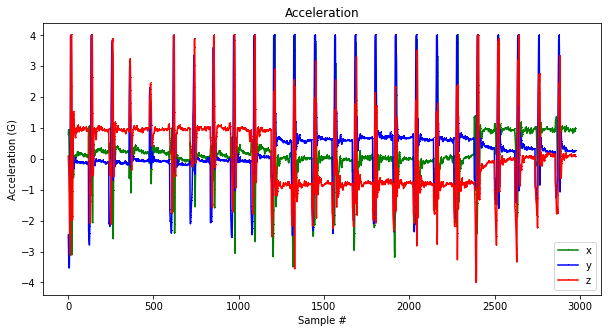

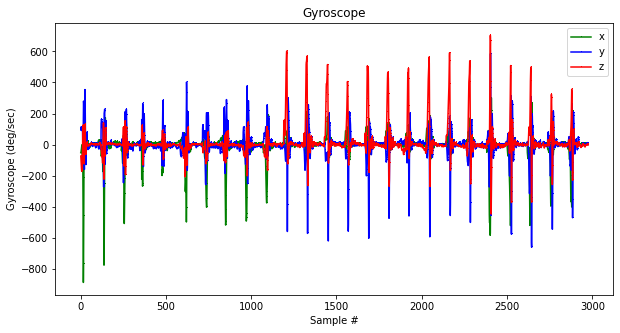

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "punch.csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (10,5)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()


In [ ]:
np.max(df["aX"]),np.min(df["aX"])

(4.0, -3.498)

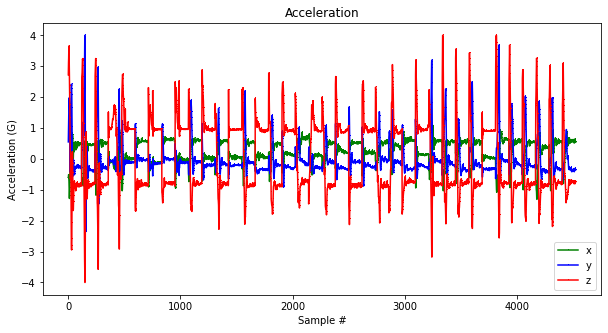

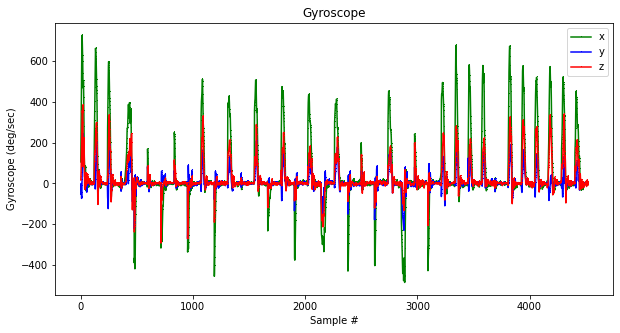

In [ ]:
filename = "flex.csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (10,5)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

# 데이터세트 구성





### punch와 flex데이터를 읽어와 데이터세트 구성


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# 랜덤시드 설정
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 데이터 수집 각 단계마다, 119개의 데이터가 기록되었음
SAMPLES_PER_GESTURE = 119

# 제스처 종류를 리스트로 지정
GESTURES = [
    "punch",
    "flex",
]

# 제스처 종류 리스트 길이
NUM_GESTURES = len(GESTURES)

# 출력에서 사용될 one-hot encoded matrix 생성
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

TensorFlow version = 2.8.0



In [ ]:
ONE_HOT_ENCODED_GESTURES

array([[1., 0.],
       [0., 1.]])

In [ ]:
inputs = []
outputs = []

for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"index : {gesture_index} gesture : '{gesture}'.")
  
  # 출력데이터 지정 (punch 일경우 [1., 0.] / flex 일경우 [0., 1.])
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  # csv 파일 로드
  df = pd.read_csv("/content/" + gesture + ".csv")
  
  # 총 몇번의 데이터기록이 이루어졌는지 확인 ( 전체데이터길이 / 119 )
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  print(f"recordings : {num_recordings} / gesture : '{gesture}'")
  
  # 데이터 전체 읽어오기 위해 for문  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j

      # acceleration : -4 ~ 4
      # gyroscopre : -2000 ~ 2000
      # Data normalization  (0~1로)
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

index : 0 gesture : 'punch'.
recordings : 25 / gesture : 'punch'
index : 1 gesture : 'flex'.
recordings : 38 / gesture : 'flex'


In [ ]:
# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)
print("Input shape:", inputs.shape)
print("Output shape:", outputs.shape)

input_size = inputs.shape[1]
print("input_size :", input_size)

Input shape: (63, 714)
Output shape: (63, 2)
input_size : 714


## 데이터 스플릿 

학습 60% / 검증 20% / 테스트 20% 로 구성

In [ ]:
# 입력길이 만큼 숫자생성 (0,1,2...62)
num_inputs = len(inputs)
randomize = np.arange(num_inputs)

# 생성된 (0,1,2...,62) 숫자 섞음
np.random.shuffle(randomize)

# 위에서 섞인 인덱스값을 이용해 데이터섞음
inputs = inputs[randomize]
outputs = outputs[randomize]

# 스플릿 숫자 지정 ( Train 60% / Validation 20% / Test 20% )
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

# 데이터 스플릿
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print(f"입력 Train shape : {inputs_train.shape}")
print(f"입력 Validation shape : {inputs_validate.shape}")
print(f"입력 Test shape : {inputs_test.shape}")
print(f"출력 Train shape : {outputs_train.shape}")
print(f"출력 Validation shape : {outputs_validate.shape}")
print(f"출력 Test shape : {outputs_test.shape}")
print("Data set randomization and splitting complete.")

입력 Train shape : (37, 714)
입력 Validation shape : (14, 714)
입력 Test shape : (12, 714)
출력 Train shape : (37, 2)
출력 Validation shape : (14, 2)
출력 Test shape : (12, 2)
Data set randomization and splitting complete.


## 모델 구성 및 학습

In [ ]:
input_size//6

119

In [ ]:
# 모델 구성 및 학습
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((input_size//6, 6), input_shape=(input_size,))) # Convolution 연산위해 shape 변경 [time_step, features]
model.add(tf.keras.layers.Conv1D(6, kernel_size=(32), activation='relu'))  
model.add(tf.keras.layers.Conv1D(3, kernel_size=(32), activation='relu')) 
model.add(tf.keras.layers.Conv1D(1, kernel_size=(32), activation='relu')) 
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) 
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(inputs_train, outputs_train, epochs=250, batch_size=1, validation_data=(inputs_validate, outputs_validate))



### Loss 그래프 plot

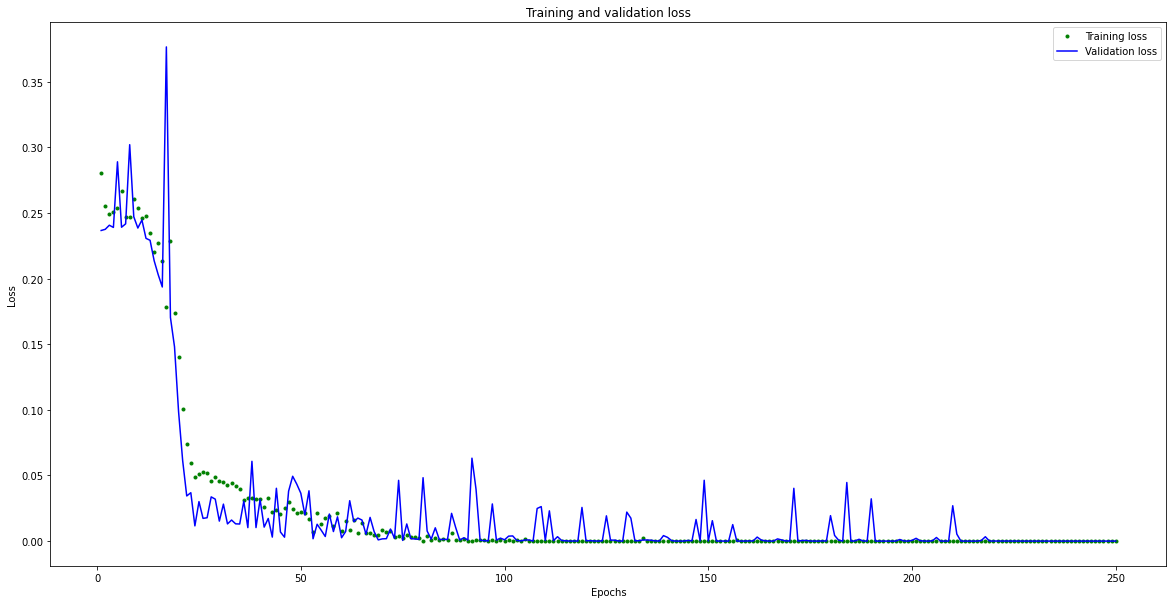

[20.0, 10.0]


In [ ]:
# 학습 Loss변화 plotting

# plot 사이즈 지정
plt.rcParams["figure.figsize"] = (10,6)

# 변수지정
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# plot
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

## 테스트

In [ ]:
# 테스트 데이터에 대해 예측
predictions = model.predict(inputs_test)

out_lst = []
pre_lst = []

for i in range(len(outputs_test)):
    out_ = np.where(outputs_test[i]==np.max(outputs_test[i]))[0][0] # [값1,값2]에 대하여 최대값(1)을 가지는 인덱스 추출
    out_lst.append(out_)

    pre_ = np.where(predictions[i]==np.max(predictions[i]))[0][0] # [값1,값2]에 대하여 최대값(1에 근접)을 가지는 인덱스 추출
    pre_lst.append(pre_)

print(out_lst)
print(pre_lst)

[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1]
[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1]


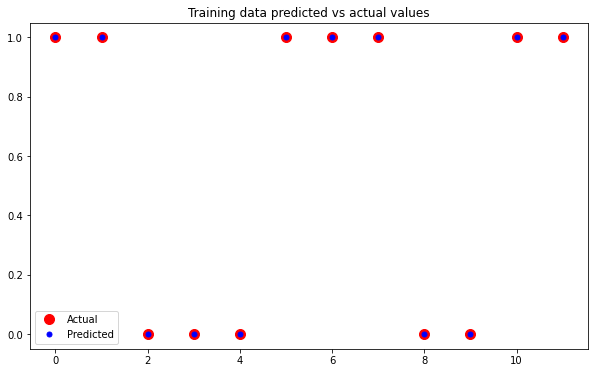

In [ ]:
plot_x = np.arange(len(outputs_test))

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(plot_x, out_lst, 'r.', label='Actual',markersize=20)
plt.plot(plot_x, pre_lst, 'b.', label='Predicted',markersize=10)

plt.title('Training data predicted vs actual values')
plt.legend()

# 학습된 모델 --> Tensorflow lite --> 아두이노 헤더파일

In [ ]:
# 학습된 모델을 tensorflow lite 형태로 변경
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 저장
open("gesture_model.tflite", "wb").write(tflite_model)

!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

INFO:tensorflow:Assets written to: /tmp/tmpco90tfvk/assets


12756